(c) 2024 Manuel Razo & David Larios. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [52]:
# Import DataFrames
import DataFrames as DF
import CSV

# Import project package
import Sandbox

# Import package for Bayesian inference
import Turing
import MCMCChains

# Import basic math
import StatsBase
import Distributions
import Random
import LinearAlgebra

# Load plotting-related packages
using CairoMakie
import ColorSchemes
import Colors
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
Sandbox.viz.theme_makie!()

# Bayesian inference for expression dynamics

In this notebook, we will explore a simple Bayesian model to infer the
parameters of an *in-vitro* gene expression system. The model we derived takes
the form
$$
p(t) = \frac{\kappa}{\gamma_m^2}D 
\left(e^{-\gamma_m t} -1 + \gamma_m t\right),
\tag{1}
$$
where $p(t)$ is the protein level at time $t$, $\kappa$ is the effective
transcription-translation rate, $\gamma_m$ is the mRNA degradation rate, and
$D$ is the DNA concentration.

Let's begin defining a function to compute the expected protein level at time
$t$


In [2]:
@doc raw"""
    p(t, κ, γ_m, D)

Compute the expected protein level at time `t` given the parameters `κ`, `γ_m`,
and `D`.

# Arguments
- `t`: Time point.
- `κ`: Effective transcription-translation rate.
- `γ_m`: mRNA degradation rate.
- `D`: DNA concentration.

# Returns
- Protein level at time `t`.
"""
function p(t, κ, γ_m, D)
    return @. (κ / γ_m^2) * D * (exp(-γ_m * t) - 1 + γ_m * t)
end


p

Let's test the function with some values changing the mRNA degradation rate
$\gamma_m$.


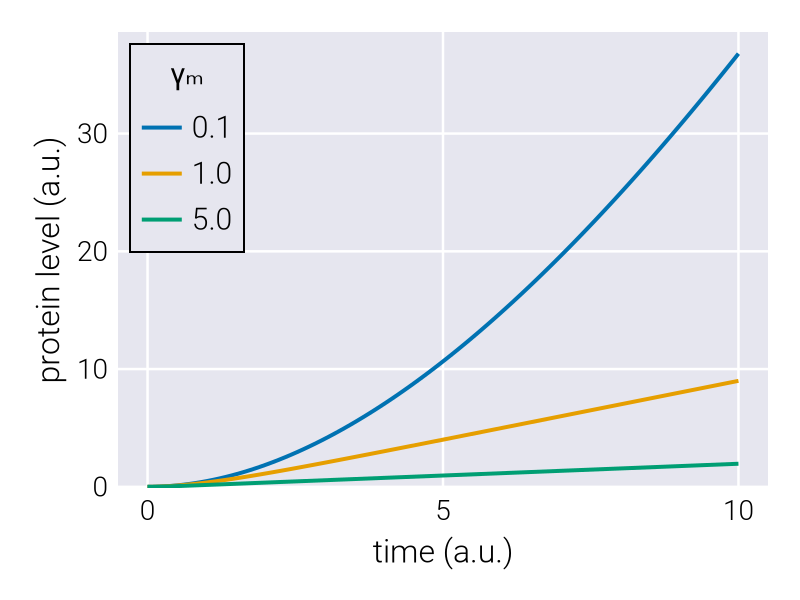

In [3]:
# Define parameters
κ = 1.0
γ_m = [0.1, 1.0, 5.0]
D = 1.0

# Define range of time points
t = range(0, 10, length=100)

# Initialize figure
fig = Figure(size=(400, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time (a.u.)",
    ylabel="protein level (a.u.)",
)

# Loop over mRNA degradation rates
for (i, γ) in enumerate(γ_m)
    # Compute expected protein level at t = 1.0
    prot = p(t, κ, γ, D)

    # Plot expected protein level
    lines!(ax, t, prot, label="$γ")
end

# Add legend
axislegend(ax, "γₘ", position=:lt)

# Set limits
ylims!(ax, low=-0.1)

fig

Let's repeat this, but changing the DNA concentration $D$.

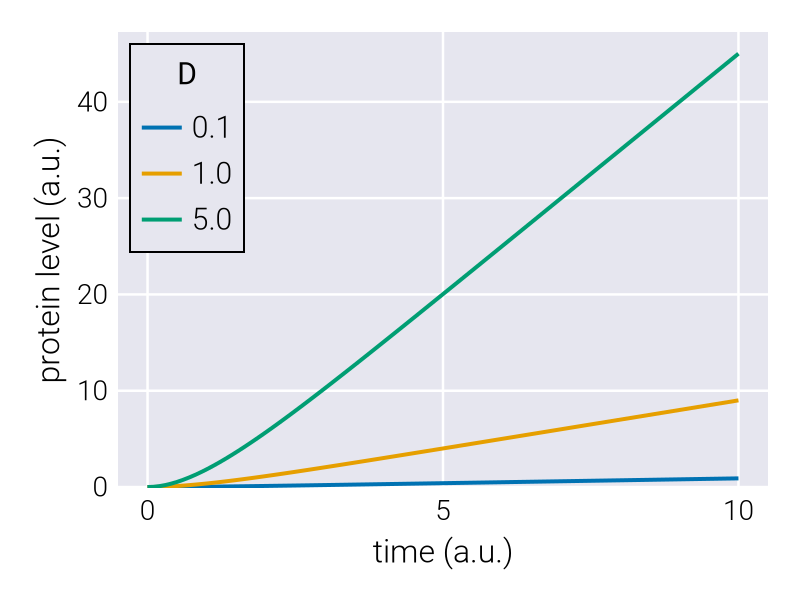

In [4]:
# Define parameters
κ = 1.0
γ_m = 1.0
D = [0.1, 1.0, 5.0]

# Define range of time points
t = range(0, 10, length=100)

# Initialize figure
fig = Figure(size=(400, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time (a.u.)",
    ylabel="protein level (a.u.)",
)

# Loop over DNA concentrations
for (i, D) in enumerate(D)
    # Compute expected protein level at t = 1.0
    prot = p(t, κ, γ_m, D)

    # Plot expected protein level
    lines!(ax, t, prot, label="$D")
end

# Add legend
axislegend(ax, "D", position=:lt)

# Set limits
ylims!(ax, low=-0.1)

fig

The function behaves more or less as expected. Let's now import the experimental
data and see if we can fit the model.

## Exploratory data analysis

Let's begin by loading the experimental data into a `DataFrame`.

In [5]:
# Define path to experimental data
data_dir = "$(git_root())/data"

# Load experimental data
df = CSV.read("$data_dir/merged_expression_PIV.csv", DF.DataFrame)

# Define columns to keep
keep_cols = [:condition, :Time_min, Symbol("Protein Concentration_nM")]

# Keep columns
df = df[!, keep_cols]

# Rename columns
DF.rename!(
    df,
    Dict(:Time_min => "time", Symbol("Protein Concentration_nM") => "prot")
)


# Show first 5 rows
first(df, 5)

Row,condition,time,prot
,String31,Float64,Float64
1,K401_0p625nM-RT,0.0,30.6308
2,K401_0p625nM-RT,1.0,30.5395
3,K401_0p625nM-RT,2.0,29.8669
4,K401_0p625nM-RT,3.0,30.5181
5,K401_0p625nM-RT,4.0,30.3145


From the `:condition` column, we need to extract some metadata. The columns are
for example `K401_0p625nM-RT`. The first part, `K401`, is the type of motor
protein, `0p625nM` is the DNA concentration, and `RT` stands for room
temperature. Let's create a new column for the motor protein type and another
for the DNA concentration.

In [6]:
# Find rows where the condition contains an underscore
idx = findall(x -> length(x) > 1, split.(df[:, :condition], "_"))
# Remove rows where the condition does not contain an underscore
df = df[idx, :]

# Extract motor protein type
df[:, :motor] = getindex.(split.(df[:, :condition], "_"), 1)

# Extract DNA concentration
df[:, :DNA] = parse.(
    Float64,
    replace.(
        getindex.(split.(getindex.(split.(df[:, :condition], "-"), 1), "_"), 2),
        "nM" => "",
        "p" => ".",
    )
)

# Add replicate column with default value 1
df[:, :replicate] .= 1

# Find columns with third entry when split by "_"
idx = findall(x -> length(x) > 2, split.(df[:, :condition], "_"))

# Parse replicate from third entry when split by "_"
df[idx, :replicate] = parse.(
    Int,
    replace.(
        getindex.(split.(df[idx, :condition], "_"), 3),
        "-RT" => "",
    )
)

first(df, 5)

Row,condition,time,prot,motor,DNA,replicate
,String31,Float64,Float64,SubStrin…,Float64,Int64
1,K401_0p625nM-RT,0.0,30.6308,K401,0.625,1
2,K401_0p625nM-RT,1.0,30.5395,K401,0.625,1
3,K401_0p625nM-RT,2.0,29.8669,K401,0.625,1
4,K401_0p625nM-RT,3.0,30.5181,K401,0.625,1
5,K401_0p625nM-RT,4.0,30.3145,K401,0.625,1


Let's now plot the :prot column over :time for each :DNA concentration and each
:motor protein type (this in a separate plot).

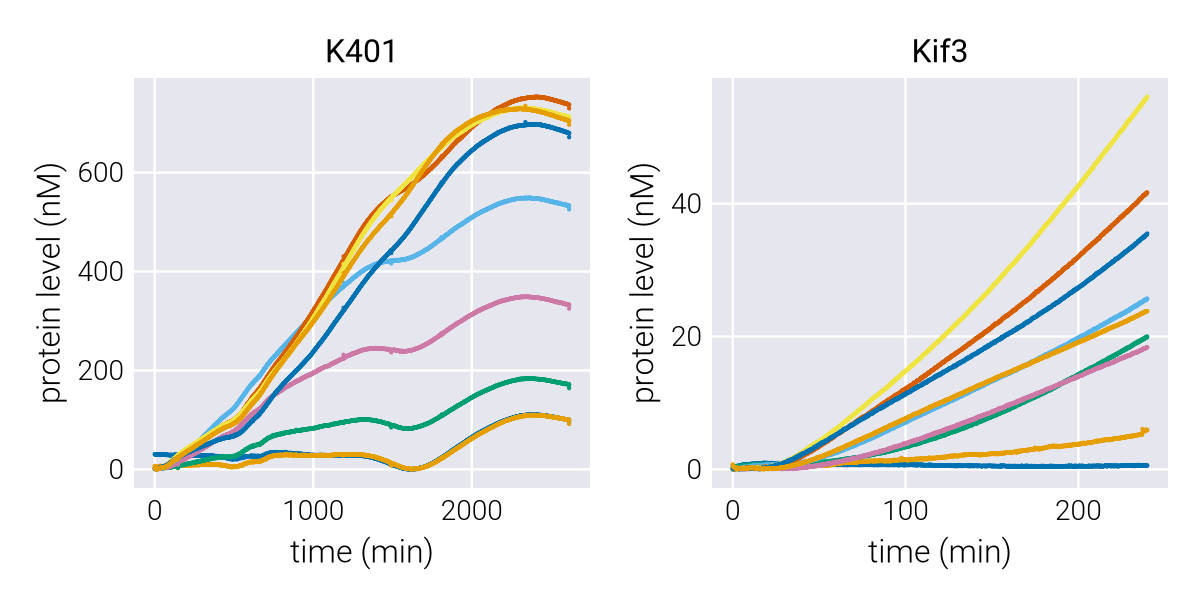

In [7]:
# Initialize figure
fig = Figure(size=(600, 300))

# Add axis for K401
ax_k401 = Axis(
    fig[1, 1],
    xlabel="time (min)",
    ylabel="protein level (nM)",
    title="K401",
)

# Add axis for Kif3a
ax_kif3a = Axis(
    fig[1, 2],
    xlabel="time (min)",
    ylabel="protein level (nM)",
    title="Kif3",
)

# Group data by :DNA and :motor
df_group = DF.groupby(df[(df.replicate.==1), :], [:DNA, :motor])

# Loop over groups
for (i, data) in enumerate(df_group)
    # Get DNA and motor
    DNA = first(data.DNA)
    motor = first(data.motor)

    # Check which axis to use
    ax = motor == "K401" ? ax_k401 : ax_kif3a

    # Plot data
    scatterlines!(
        ax,
        data.time,
        data.prot,
        label="$DNA",
        markersize=3,
    )
end

fig

## Bayesian inference

We are now ready to fit the model to the data. We will use a simple Bayesian
model of the following form:

**Priors**

$$
\gamma_m \sim \text{Gamma}(\alpha_\gamma, \beta_\gamma),
\tag{2}
$$
and
$$
\kappa \sim \text{Gamma}(\alpha_\kappa, \beta_\kappa),
\tag{3}
$$
and
$$
\sigma_p \sim \text{Half}-\mathcal{N}(0, \sigma_p^\text{max}).
\tag{4}
$$

**Likelihood**

$$
p(t_i) \mid \gamma_m, \kappa, \sigma_p, t_i \sim
\mathcal{N}(p(t_i, \kappa, \gamma_m, D), \sigma_p^2).
\tag{5}
$$


Let's define the `Turing` model.

In [55]:
# Define model
Turing.@model function bayesian_drops(
    prot, t, DNA;
    α_γ=2.0, β_γ=0.1, α_κ=2.0, β_κ=0.1, σ_p_max=10.0
)
    # Define priors
    γ_m ~ Turing.Gamma(α_γ, β_γ)
    κ ~ Turing.Gamma(α_κ, β_κ)
    σ_p ~ Turing.Truncated(Turing.Normal(0.0, σ_p_max), 0.0, Inf)

    # Define likelihood
    prot ~ Turing.MvNormal(
        p(t, κ, γ_m, DNA),
        LinearAlgebra.Diagonal(fill(σ_p^2, length(t)))
    )

    # return interesting quantities
    return prot
end

bayesian_drops (generic function with 2 methods)

We are now ready to fit the model to the data. Let's first try to fit the model
for a single DNA concentration.

In [56]:
Random.seed!(42)

# Extract data
data = df[
    (df.DNA.==160.0).&(df.motor.=="Kif3").&(df.replicate.==1),
    :]

# Extract protein, time, and DNA concentration
prot = data.prot
t = data.time
DNA = data.DNA

# Define model
bayesian_drops_model = bayesian_drops(prot, t, DNA)

# Sample from the posterior
chain = Turing.sample(
    bayesian_drops_model,
    Turing.NUTS(),
    Turing.MCMCThreads(),
    1500,
    4,
    progress=false
)

# Show summary
Turing.summarystats(chain)

┌ Info: Found initial step size
│   ϵ = 7.62939453125e-7
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/KamI0/src/mcmc/hmc.jl:202
┌ Info: Found initial step size
│   ϵ = 3.0517578125e-6
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/KamI0/src/mcmc/hmc.jl:202
┌ Info: Found initial step size
│   ϵ = 3.0517578125e-6
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/KamI0/src/mcmc/hmc.jl:202
┌ Info: Found initial step size
│   ϵ = 4.76837158203125e-8
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/KamI0/src/mcmc/hmc.jl:202


Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

         γ_m    0.0234    0.0002    0.0000    950.3377   1161.4290    1.0016   ⋯
           κ    0.0000    0.0000    0.0000    960.0338   1251.1599    1.0017   ⋯
         σ_p    0.3397    0.0057    0.0001   4751.0180   3799.7481    1.0003   ⋯
                                                                1 column omitted


Let's take a look at the posterior distributions of the parameters with a
trace-density plot.

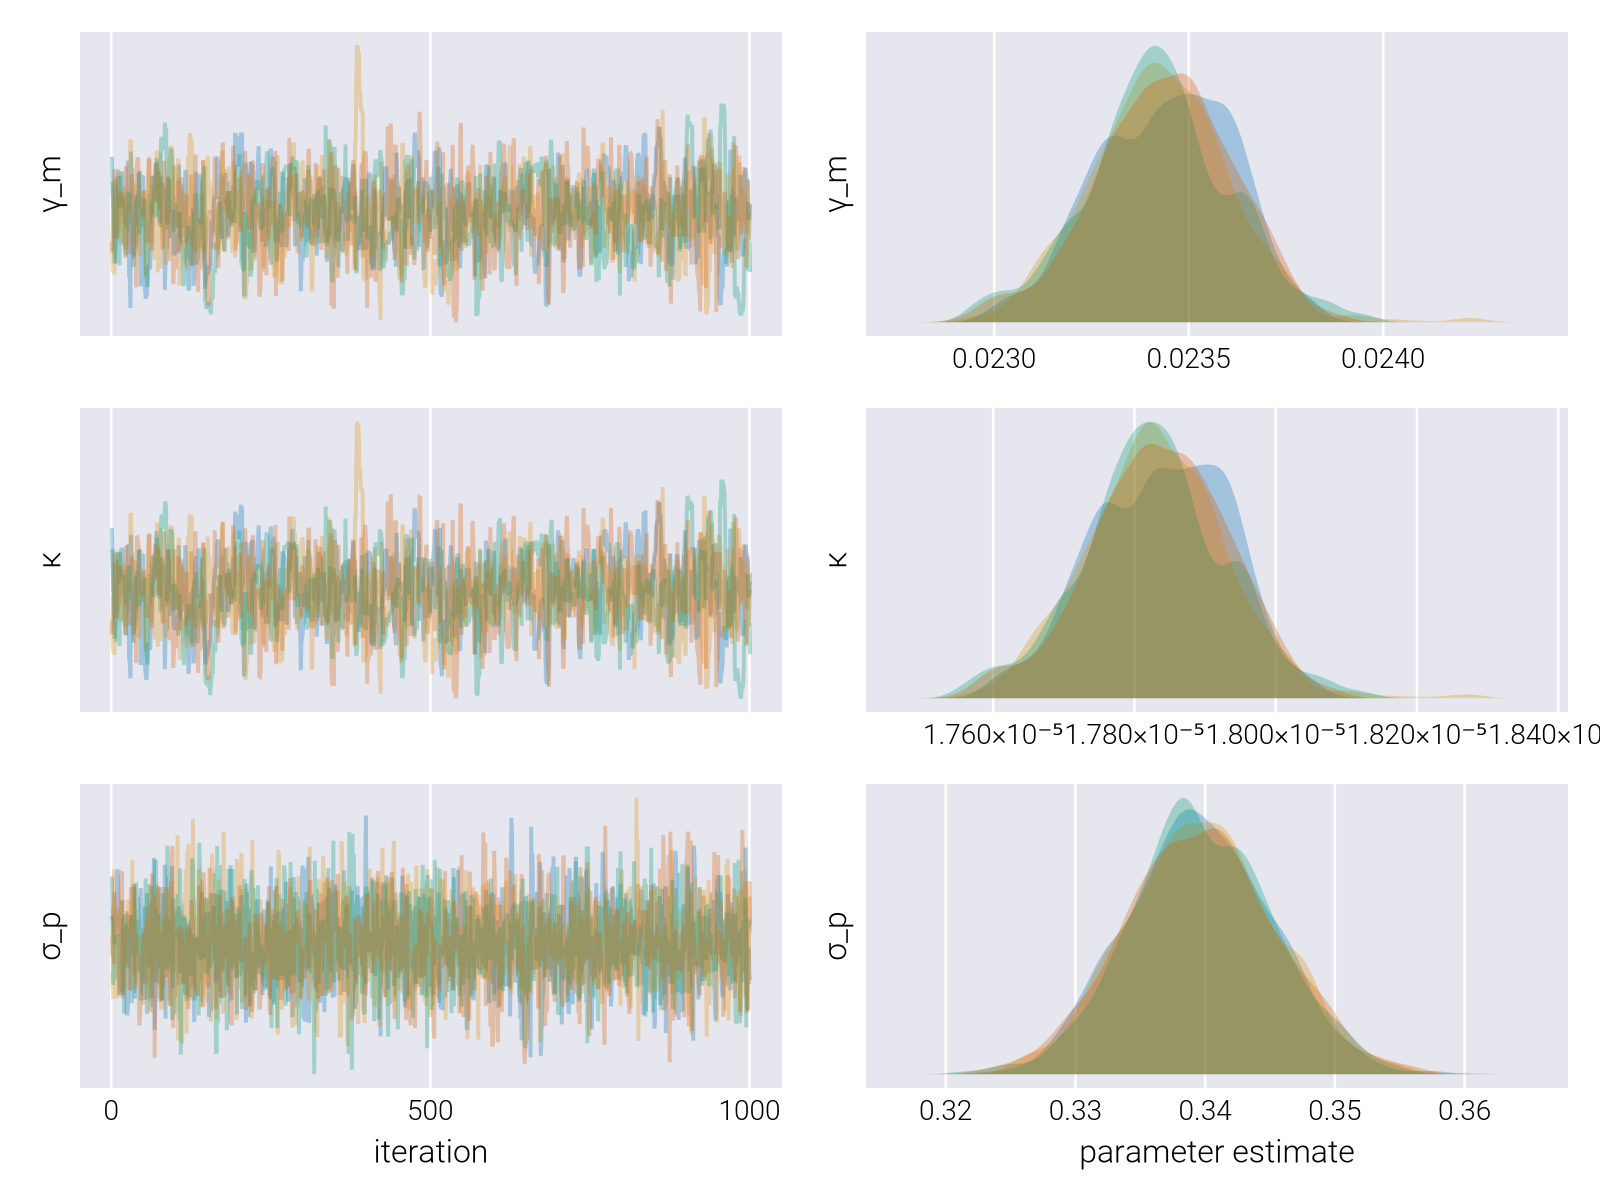

In [72]:
# Remove burn-in
chain = chain[500:end, :, :]

# Extract parameters
params = names(chain, :parameters)

# Extract number of chains
n_chains = length(MCMCChains.chains(chain))
# Extract number of parameters
n_samples = length(chain)

# Initialize figure
fig = Figure(size=(800, 600))

# Define colors
colors = ColorSchemes.seaborn_colorblind

# Loop through parameters
for (i, param) in enumerate(params)
    # Add axis for chain iteration
    ax_trace = Axis(fig[i, 1]; ylabel=string(param))
    # Inititalize axis for density plot
    ax_density = Axis(fig[i, 2]; ylabel=string(param))
    # Loop through chains
    for chn in 1:n_chains
        # Extract values
        values = chain[:, param, chn]
        # Plot traces of walker
        lines!(
            ax_trace,
            1:n_samples,
            values;
            label=string(chain),
            color=(colors[chn], 0.3)
        )
        # Plot density
        density!(
            ax_density, values; label=string(chain), color=(colors[chn], 0.3)
        )
    end # for

    # Hide y-axis decorations
    hideydecorations!(ax_trace; label=false)
    hideydecorations!(ax_density; label=false)

    # Check if it is bottom plot
    if i < length(params)
        # hide x-axis decoratiosn
        hidexdecorations!(ax_trace; grid=false)
    else
        # add x-label
        ax_trace.xlabel = "iteration"
        ax_density.xlabel = "parameter estimate"
    end # if
end # for

fig

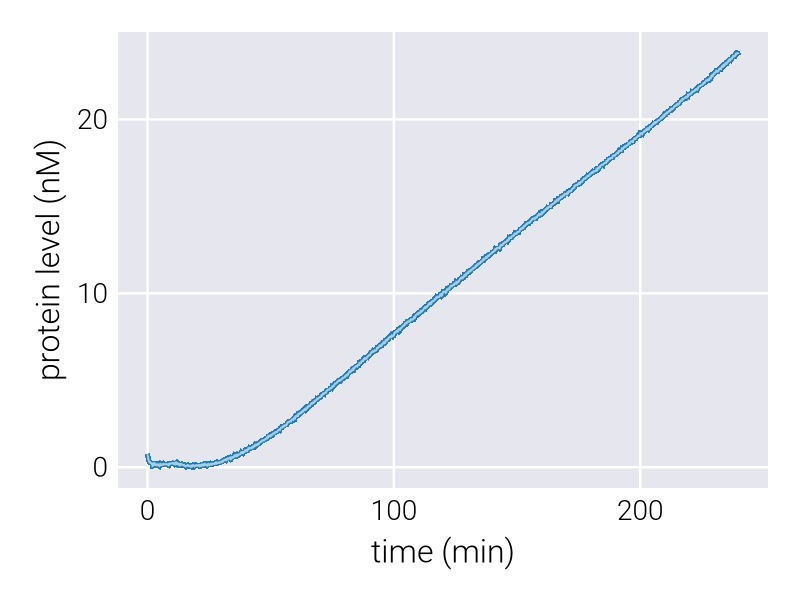

In [58]:
# Initialize figure
fig = Figure(size=(400, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time (min)",
    ylabel="protein level (nM)",
)

# Extract posterior predictive samples
ppc = Turing.generated_quantities(bayesian_drops_model, chain)[1:50:end]

# Loop through each ppc
for (i, ppc_sample) in enumerate(ppc)
    # Plot ppc sample
    lines!(ax, t, ppc_sample, color=ColorSchemes.Paired_10[2])
end

# Plot experimental data
lines!(ax, t, prot, color=ColorSchemes.Paired_10[1], linewidth=1)

fig

Let's do our own posterior predictive check.

In [73]:
Random.seed!(42)

# Define number of samples
n_ppc_samples = 1_000

# Initialize array to store samples
ppc_samples = zeros(n_samples, length(t))

# Extract parameters
params = names(chain, :parameters)
# Extract number of chains
n_chains = length(MCMCChains.chains(chain))
# Extract number of parameters
n_samples = length(chain)

# Loop through samples
for i in 1:n_ppc_samples
    # Sample chain index
    chn_idx = rand(1:n_chains)
    # Sample sample index
    samp_idx = rand(1:n_samples)
    # Extract parameter samples
    γ_m, κ, σ_p = [chain[samp_idx, par, chn_idx] for par in params]
    # Compute posterior predictive sample
    ppc_samples[i, :] = rand(
        Turing.MvNormal(
            p(t, κ, γ_m, DNA[1]),
            LinearAlgebra.Diagonal(fill(σ_p^2, length(t)))
        )
    )
end # for

Let's compute the quantiles for the posterior predictive samples.

In [74]:
# Define quantiles to compute
qs = [0.995, 0.95, 0.5]

# Inititalize array to save quantiles
ppc_quant = [Array{Float64}(undef, size(ppc_samples, 2), 2) for x = 1:length(qs)]

# Loop through quantiles
for (i, q) in enumerate(qs)
    # Loop through time points
    for t in 1:size(ppc_samples, 2)
        # Extract data
        ppc_data = ppc_samples[:, t]

        # Compute uper and lower quantile
        ppc_quant[i][t, :] = StatsBase.quantile(
            ppc_data, [(1.0 - q) / 2.0, 1.0 - (1.0 - q) / 2.0]
        )
    end # for
end # for

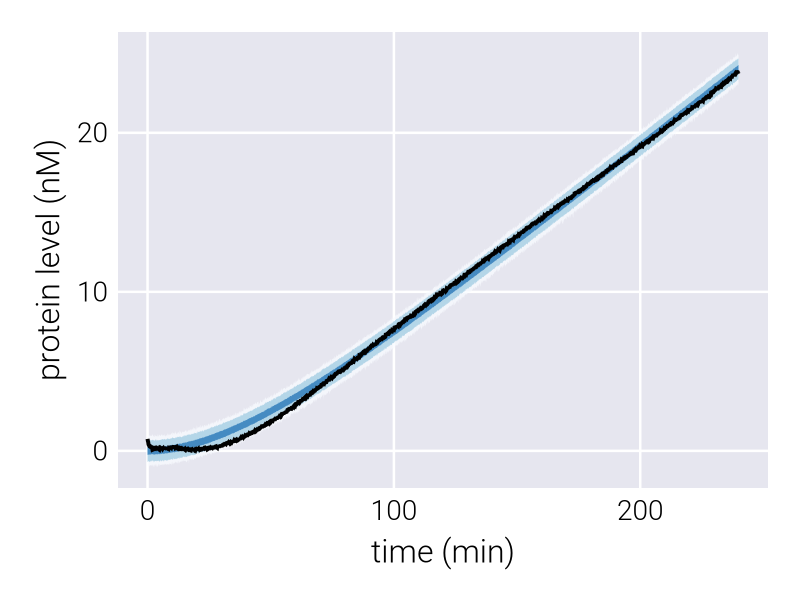

In [75]:
# Initialize figure
fig = Figure(size=(400, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time (min)",
    ylabel="protein level (nM)",
)

# Define colors
colors = get(ColorSchemes.Blues_9, LinRange(0, 0.75, 3))

# Loop through quantiles
for (i, q) in enumerate(qs)
    # Plot quantile as band
    band!(
        ax,
        t,
        ppc_quant[i][:, 1],
        ppc_quant[i][:, 2],
        color=(colors[i], 0.75)
    )
end

# Plot experimental data
lines!(ax, t, prot, color=:black)

fig

This looks really good! Let's now try fitting the model using all of the DNA
concentrations.

In [77]:
Random.seed!(42)

# Extract data
data = df[(df.motor.=="Kif3").&(df.replicate.==1), :]

# Extract protein, time, and DNA concentration
prot = data.prot
t = data.time
DNA = data.DNA

# Define model
bayesian_drops_model = bayesian_drops(prot, t, DNA)

# Sample from the posterior
chain = Turing.sample(
    bayesian_drops_model,
    Turing.NUTS(),
    Turing.MCMCThreads(),
    1500,
    4,
    progress=false
)

# Show summary
Turing.summarystats(chain)

┌ Info: Found initial step size
│   ϵ = 7.62939453125e-7
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/KamI0/src/mcmc/hmc.jl:202
┌ Info: Found initial step size
│   ϵ = 3.0517578125e-6
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/KamI0/src/mcmc/hmc.jl:202
┌ Info: Found initial step size
│   ϵ = 4.76837158203125e-8
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/KamI0/src/mcmc/hmc.jl:202
┌ Info: Found initial step size
│   ϵ = 3.0517578125e-6
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/KamI0/src/mcmc/hmc.jl:202


Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

         γ_m    0.0211    0.0028    0.0001   1822.2206   1730.1666    1.0026   ⋯
           κ    0.0000    0.0000    0.0000   1809.2570   1764.5504    1.0025   ⋯
         σ_p   11.8443    0.0659    0.0011   3285.6539   2802.5129    1.0010   ⋯
                                                                1 column omitted


Again, let's look at the trace-density plot.

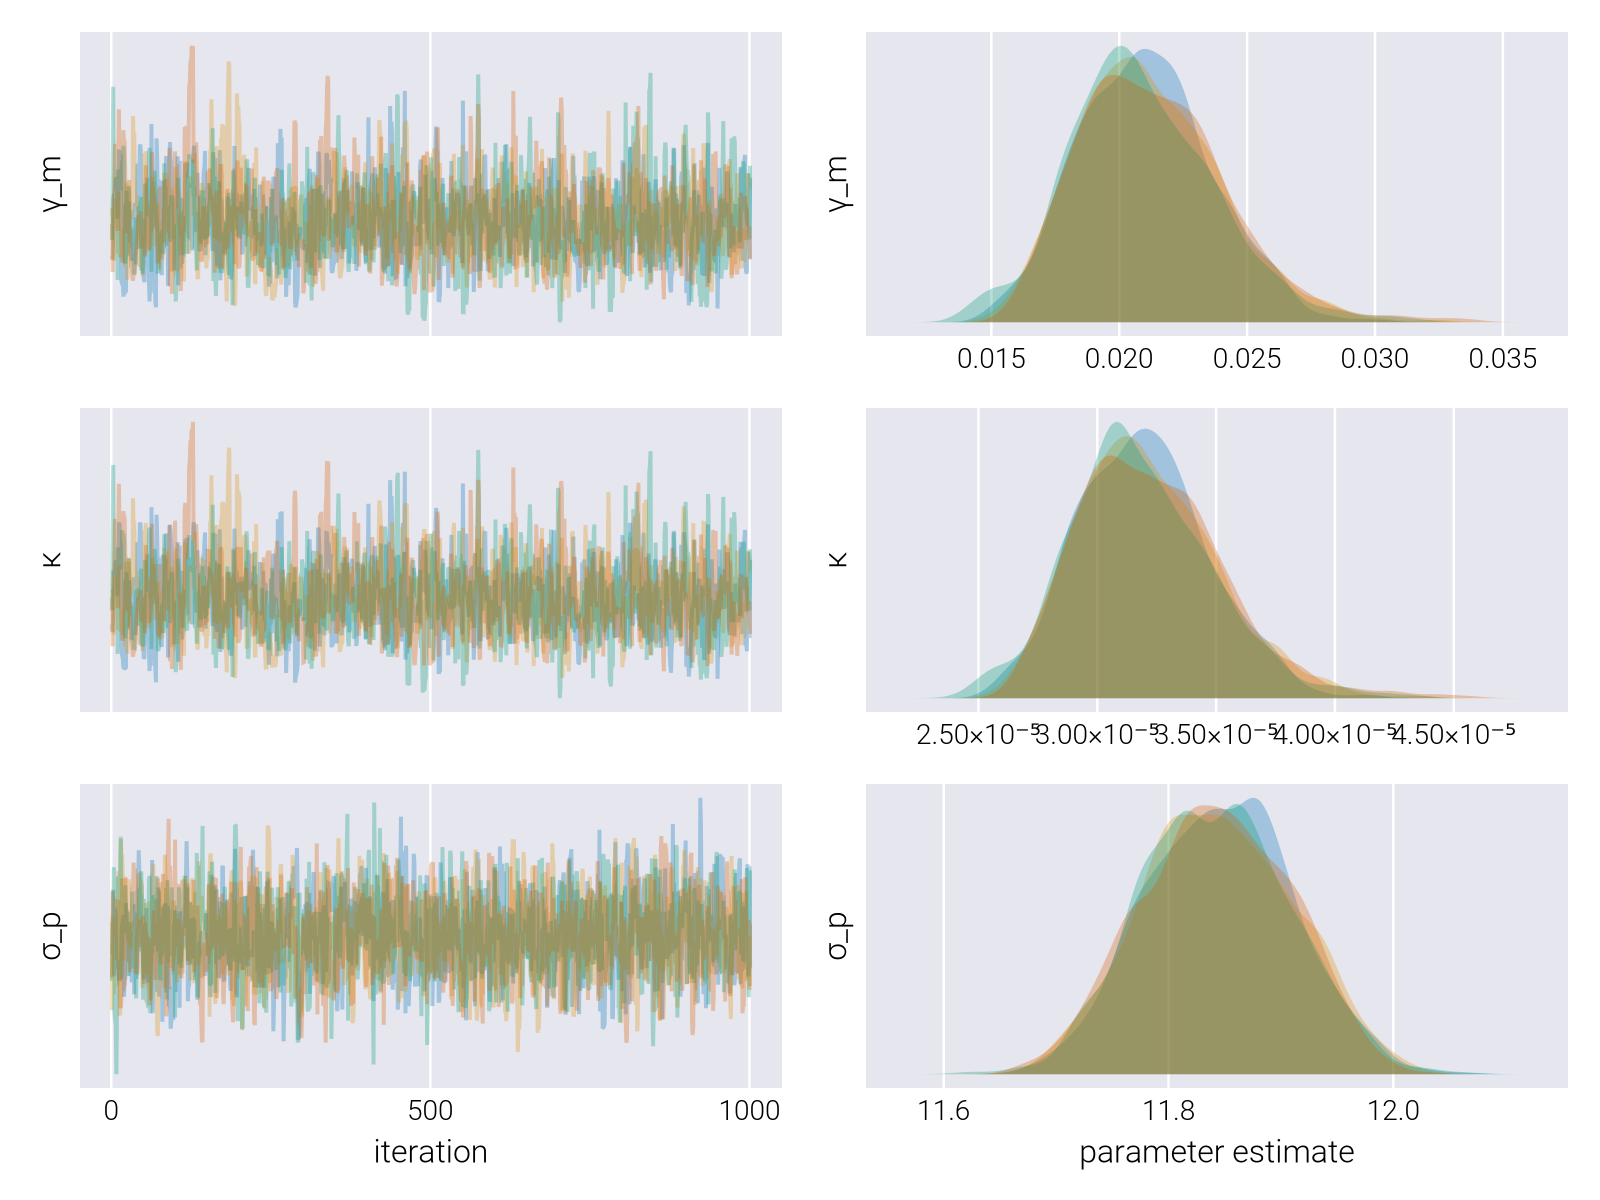

In [78]:
# Remove burn-in
chain = chain[500:end, :, :]

# Extract parameters
params = names(chain, :parameters)

# Extract number of chains
n_chains = length(MCMCChains.chains(chain))
# Extract number of parameters
n_samples = length(chain)

# Initialize figure
fig = Figure(size=(800, 600))

# Define colors
colors = ColorSchemes.seaborn_colorblind

# Loop through parameters
for (i, param) in enumerate(params)
    # Add axis for chain iteration
    ax_trace = Axis(fig[i, 1]; ylabel=string(param))
    # Inititalize axis for density plot
    ax_density = Axis(fig[i, 2]; ylabel=string(param))
    # Loop through chains
    for chn in 1:n_chains
        # Extract values
        values = chain[:, param, chn]
        # Plot traces of walker
        lines!(
            ax_trace,
            1:n_samples,
            values;
            label=string(chain),
            color=(colors[chn], 0.3)
        )
        # Plot density
        density!(
            ax_density, values; label=string(chain), color=(colors[chn], 0.3)
        )
    end # for

    # Hide y-axis decorations
    hideydecorations!(ax_trace; label=false)
    hideydecorations!(ax_density; label=false)

    # Check if it is bottom plot
    if i < length(params)
        # hide x-axis decoratiosn
        hidexdecorations!(ax_trace; grid=false)
    else
        # add x-label
        ax_trace.xlabel = "iteration"
        ax_density.xlabel = "parameter estimate"
    end # if
end # for

fig

Let's generate posterior predictive samples.

In [84]:
Random.seed!(42)

# Define number of ppc samples
n_ppc_samples = 1_000

# Group data by DNA concentration
data_group = DF.groupby(data, :DNA)

# Initialize array to store samples
ppc_samples = [
    zeros(n_ppc_samples, size(data_group[x], 1))
    for x = 1:length(data_group)
]

# Extract parameters
params = names(chain, :parameters)
# Extract number of chains
n_chains = length(MCMCChains.chains(chain))
# Extract number of parameters
n_samples = length(chain)

# Loop through samples
for i in 1:n_ppc_samples
    # Sample chain index
    chn_idx = rand(1:n_chains)
    # Sample sample index
    samp_idx = rand(1:n_samples)
    # Extract parameter samples
    γ_m, κ, σ_p = [chain[samp_idx, par, chn_idx] for par in params]

    # Loop through data groups
    for (j, d) in enumerate(data_group)
        # Compute posterior predictive sample
        ppc_samples[j][i, :] = rand(
            Turing.MvNormal(
                p(d.time, κ, γ_m, d.DNA),
                LinearAlgebra.Diagonal(fill(σ_p^2, length(d.time)))
            )
        )
    end # for
end # for

Let's compute the quantiles for the posterior predictive samples.

In [88]:
# Define quantiles to compute
qs = [0.995, 0.95, 0.5]

# Inititalize array to save quantiles
ppc_quant = [
    [Array{Float64}(undef, size(ppc_samples[x], 2), 2) for x = 1:length(qs)]
    for x = 1:length(data_group)
]

# Loop through quantiles
for (i, q) in enumerate(qs)
    # Loop through data groups
    for (j, d) in enumerate(data_group)
        # Loop through time points
        for t in 1:size(ppc_samples[j], 2)
            # Extract data
            ppc_data = ppc_samples[j][:, t]

            # Compute uper and lower quantile
            ppc_quant[j][i][t, :] = StatsBase.quantile(
                ppc_data, [(1.0 - q) / 2.0, 1.0 - (1.0 - q) / 2.0]
            )
        end # for
    end # for
end # for

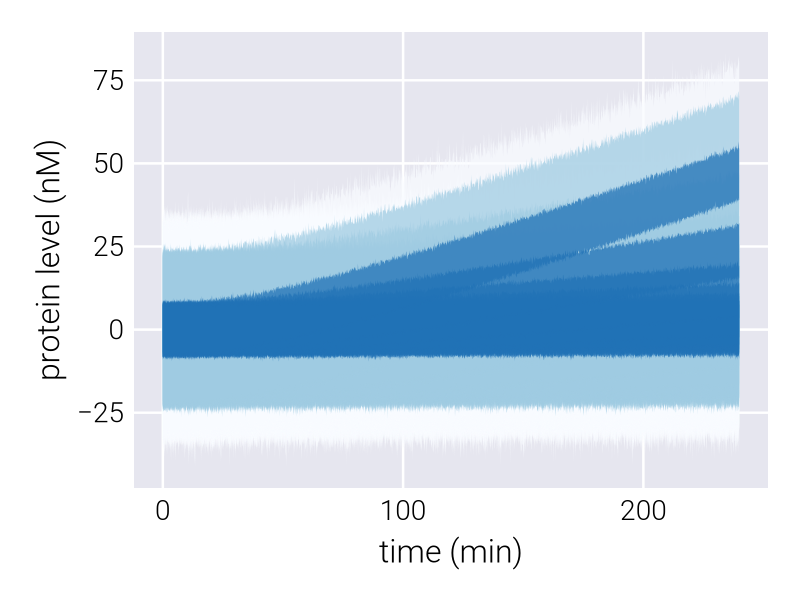

In [91]:
# Initialize figure
fig = Figure(size=(400, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time (min)",
    ylabel="protein level (nM)",
)

# Define colors
colors = get(ColorSchemes.Blues_9, LinRange(0, 0.75, 3))

# Loop through quantiles
for (i, q) in enumerate(qs)
    # Loop through data groups
    for (j, d) in enumerate(data_group)
        # Plot quantile as band
        band!(
            ax,
            d.time,
            ppc_quant[j][i][:, 1],
            ppc_quant[j][i][:, 2],
            color=(colors[i], 0.75)
        )
    end # for
end # for

# Plot experimental data
# lines!(ax, t, prot, color=:black)

fig